# DISCOVER-AQ Maryland (2011)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%pylab inline

matplotlib.rcParams.update({'font.size': 16})

Populating the interactive namespace from numpy and matplotlib


## Retrieve GEOS-Chem data along flighttracks

GC output: Tracers past 67 are not assigned.

In [7]:
cpdc = {'NOx': 'TRA_068', 'PAN': 'TRA_003', 'HNO3': 'TRA_007', \
        'R4N2': 'TRA_017', 'NH3': 'TRA_030', 'O3': 'TRA_002', \
        'CO': 'TRA_004', 'H2O2': 'TRA_008', 'SO2': 'TRA_026', \
        'NOy': 'NOy'}

In [8]:
dates = np.arange(20110701, 20110730)

plog = 'Planeflight.log.'
dat = pd.read_csv('../../planeflights/' + plog + str(dates[0]), sep='\s*', engine='python')
dsc_mon = dat[dat["TYPE"]=='DISCO']

for dt in dates:
    day_dat = 0
    dsc_day = 0
    day_dat = pd.read_csv('../../planeflights/' + plog + str(dt), sep='\s*', engine='python')
    dsc_day = day_dat[day_dat["TYPE"]=="DISCO"]
    dsc_mon = pd.concat([dsc_mon, dsc_day])

dsc_mon['TRA_068'] = dsc_mon['TRA_001'] + dsc_mon['TRA_064'] # NOx

In [ ]:
list(dsc_mon)

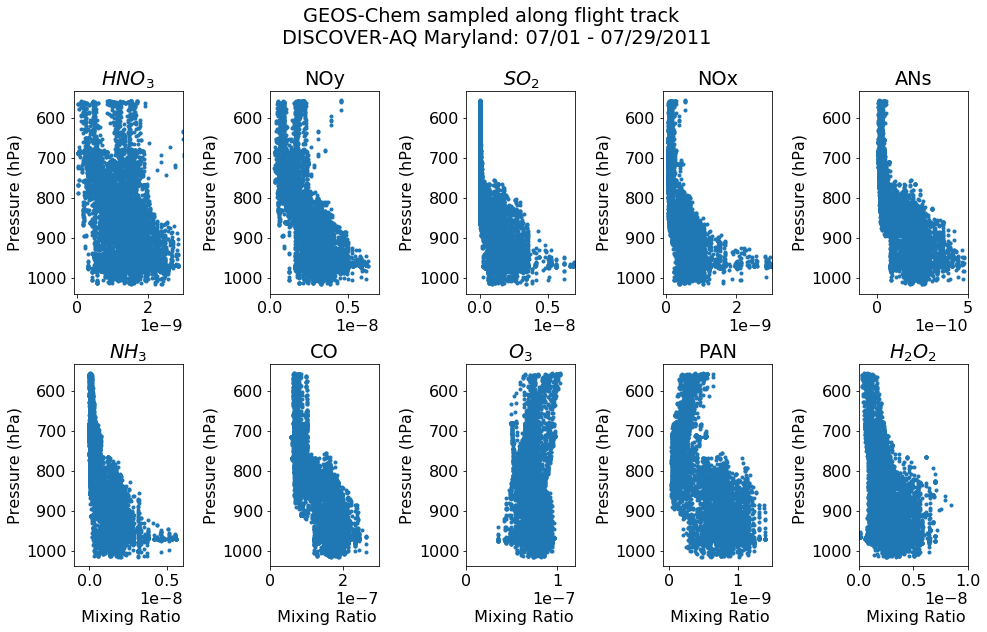

In [10]:
fig = plt.figure(figsize=[14,9])
for idx, cp in enumerate(cpdc):
    fig.add_subplot(2,5 ,idx+1)
    plt.scatter(np.ma.masked_invalid(dsc_mon[cpdc[cp]]), dsc_mon['PRESS'], marker = '.')
    plt.gca().invert_yaxis()
    
    if cp == 'HNO3':
        plt.xlim([-0.1e-9, 3.0e-9])
        plt.title(r'$HNO_3$')
    elif cp == 'SO2':
        plt.xlim([-0.1e-8, 0.7e-8])
        plt.title(r'$SO_2$')
    elif cp == 'NOx':
        plt.xlim([-0.1e-9, 3.0e-9])
        plt.title(cp)
    elif cp == 'R4N2':
        plt.xlim([-0.1e-9, 5e-10])
        plt.title('ANs')
    elif cp == 'NH3':
        plt.xlim([-0.1e-8, 0.6e-8])
        plt.title(r'$NH_3$')
    elif cp == 'CO':
        plt.xlim([0., 3.0e-7])
        plt.title(cp)
    elif cp == 'O3':
        plt.xlim([0., 1.2e-7])
        plt.title(r'$O_3$')
    elif cp == 'NOy':
        plt.xlim([0., 0.7e-8])
        plt.title(cp)
    elif cp == 'PAN':
        plt.xlim([-0.1e-9, 1.5e-9])
        plt.title(cp)
    elif cp == 'H2O2':
        plt.xlim([0., 1.0e-8])
        plt.title(r'$H_2O_2$')
    
    if idx==0 or 5:
        plt.ylabel('Pressure (hPa)')
    if idx>4:
        plt.xlabel('\n Mixing Ratio')
        
plt.suptitle('GEOS-Chem sampled along flight track \n DISCOVER-AQ Maryland: 07/01 - 07/29/2011')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

## Retrieve aircraft observations

In [11]:
pdat = 'Planeflight.dat.'
odat = pd.read_csv('../../flighttracks/2011/07/' + pdat + str(dates[0]) + '.csv', sep=',', engine='python')
dsc_obm = odat[odat['campaign']=='DISCOVER-AQ-DC-WP3B']

for dt in dates:
    day_dat = 0
    dsc_day = 0
    day_dat = pd.read_csv('../../flighttracks/2011/07/' + pdat + str(dt) + '.csv', sep=',', engine='python')
    dsc_obd = day_dat[day_dat['campaign']=='DISCOVER-AQ-DC-WP3B']
    dsc_obm = pd.concat([dsc_obm, dsc_obd])

dsc_obm['ANs_TD.LIF'] = dsc_obm['ANs_TD.LIF']/1e12 # convert from ppt to MR

In [ ]:
dsc_obm['VPD'] = dsc_obm['C_SatVaporPresWater'] - dsc_obm['C_VaporPresWater']
list(dsc_obm)

The observations include NOx, $HNO_3$, ANs, $O_3$, CO and NOy. PAN_P, PANe_P, SO2_ppbv are empty; no $H_2O_2$ or $NH_3$. Note that ANs are in pptv and must be converted.

In [13]:
# Variables in common:
vrs = {'NOx': ['NOx', 'TRA_068'], 'HNO3': ['HNO3', 'TRA_007'], \
       'O3': ['O3', 'TRA_002'], 'ANs': ['ANs_TD.LIF', 'TRA_017'], \
       'CO': ['CO', 'TRA_004'], 'NOy': ['NOy', 'NOy']}


## Compare model and aircraft observations

### Organize data for simplified vertical profiles

In [14]:
# Calculate mean pressure over several intervals
# Observations
dsc_obm['NOx'] = dsc_obm['NO'] + dsc_obm['NO2_NCAR']
dsc_obm_s = dsc_obm.sort_values('press')
olen = len(dsc_obm_s[6:])
oprs = dsc_obm_s['press'][6:].values.reshape(8, olen/8)
mopr = np.mean(oprs, axis=1)

# Model
dsc_mon_s = dsc_mon.sort_values('PRESS')
dsc_mon_s['NOx'] = dsc_mon_s['NO'] + dsc_mon_s['NO2']
tlen = len(dsc_mon_s[4:]) # truncate to allow more pressure levels
pres = dsc_mon_s['PRESS'][4:].values.reshape(8, tlen/8)
mprs = np.mean(pres, axis=1)

### Plotting campaign mean

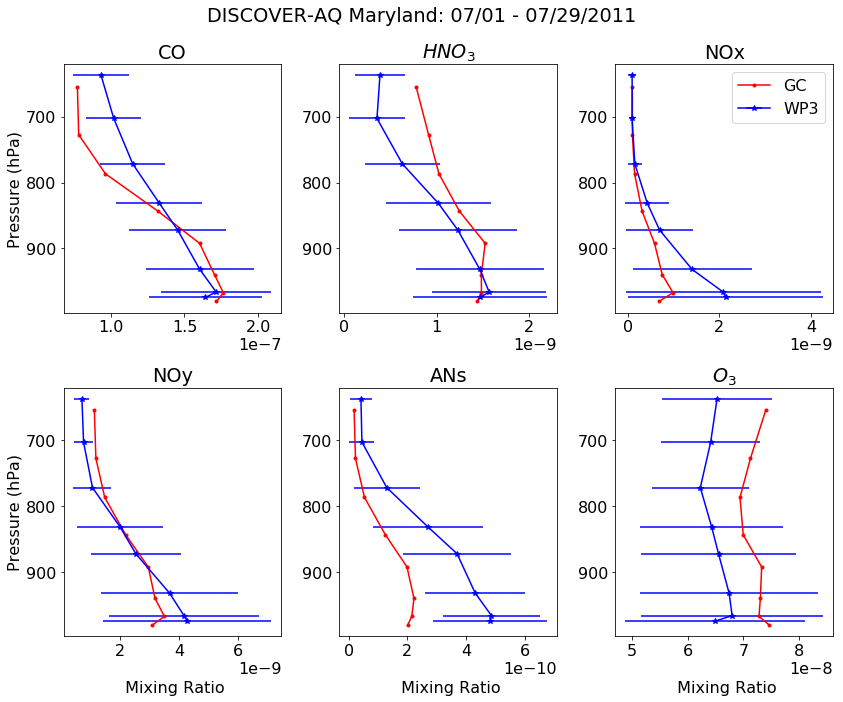

In [16]:
fig = plt.figure(figsize=[12,10])
for idx, cp in enumerate(vrs):
    fig.add_subplot(2, 3, idx+1)
    
    # Mask observations where negative in order to take interval mean
    odat = dsc_obm_s[vrs[cp][0]][6:].values.reshape(8, olen/8)
    modt = np.ma.masked_invalid(odat) # some values also NaN
    mask = modt < 0
    modt = np.ma.masked_array(modt, mask)
    mmod = np.mean(modt, axis=1)
    osdv = np.std(modt, axis=1)
        
    # Model interval mean
    mdat = np.mean(dsc_mon_s[vrs[cp][1]][4:].values.reshape(8, tlen/8), axis=1)
    #msdv = np.std(dsc_mon_s[vrs[cp][1]][4:].values.reshape(8, tlen/8), axis=1)
    
    # Plotting
    plt.errorbar(mmod, mopr, color='b', xerr=osdv, marker= '*', label='WP3')
    plt.plot(mdat, mprs, color='r', marker= '.', label='GC')
    plt.gca().invert_yaxis()
    if cp == 'HNO3':
        plt.title(r'$HNO_3$')
    elif cp == 'O3':
        plt.title(r'$O_3$')
    else:
        plt.title(cp)
    
    if idx == 0:
        plt.ylabel('Pressure (hPa)')
    elif idx == 3:
        plt.ylabel('Pressure (hPa)')
    if idx > 2:
        plt.xlabel('\n Mixing Ratio')
    if idx == 2:
        plt.legend(loc='best')

plt.suptitle('DISCOVER-AQ Maryland: 07/01 - 07/29/2011')
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig('disco/disco_prof.jpg')

## Subset aircraft data by meteorological observations

In [36]:
def metsub(dat, varn, cmap, desc):
    fig = plt.figure(figsize=[14,9])
    for idx, var in enumerate(vrs):
        fig.add_subplot(2,3 ,idx+1)
        met = dat[varn]
        obj = plt.scatter(np.ma.masked_invalid(dat[vrs[var][0]]), dat['press'], c=met, cmap=cmap, marker = '.')
        plt.gca().invert_yaxis()
            
        if var=='CO':
            plt.xlim([0.5e-7, 2.5e-7])
            plt.title(var)
        elif var=='O3':
            plt.xlim([0., 1.5e-7])
            plt.title(r'$O_3$')
            #plt.colorbar(obj)
        elif var=='ANs':
            plt.xlim([-0.8e-10, 1.3e-9])
            plt.title(var)
        elif var=='HNO3':
            plt.xlim([-0.2e-9, 6e-9])
            plt.title(r'$HNO_3$')
        else:
            plt.xlim([-0.2e-9, 1.2e-8])
            plt.title(var)
            
        if idx==0 or 3:
            plt.ylabel('Pressure (hPa)')
        if idx>2:
            plt.xlabel('\n Mixing Ratio')
            
    cbar_ax = fig.add_axes([0.95, 0.15, 0.04, 0.7])
    fig.colorbar(obj, cax=cbar_ax)
    plt.suptitle(desc + '\n DISCOVER-AQ Maryland: 07/01 - 07/29/2011')
    plt.tight_layout()
    plt.subplots_adjust(top=0.87, right=0.9)
    return fig;

### Temperature

##### Surface Temperature

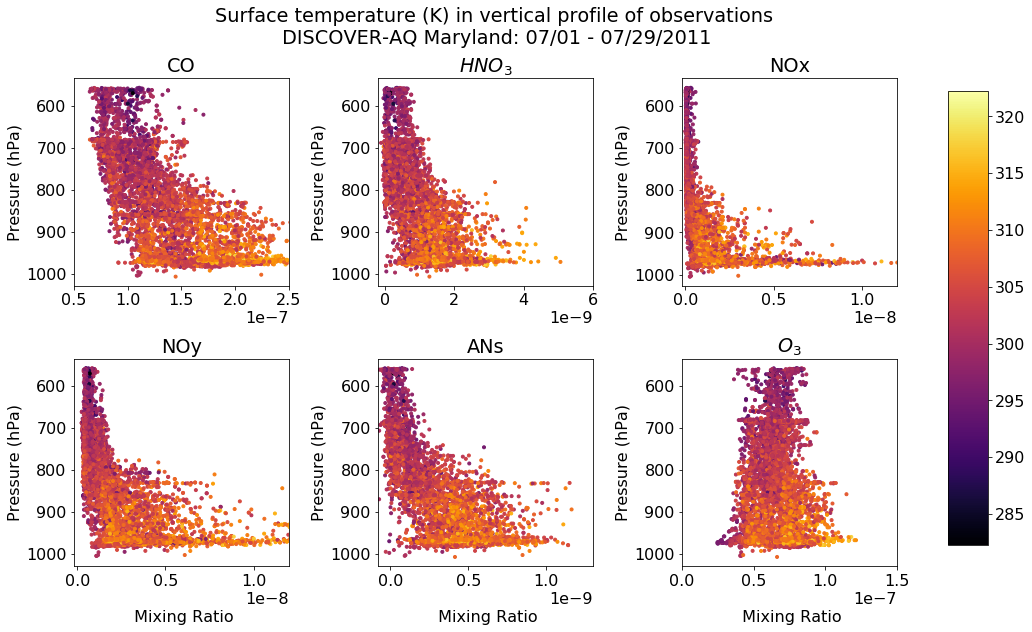

In [37]:
st = metsub(dsc_obm, 'A_SurfTemp', 'inferno', 'Surface temperature (K) in vertical profile of observations')
plt.savefig('disco/disco_st.jpg')

##### Total Temperature

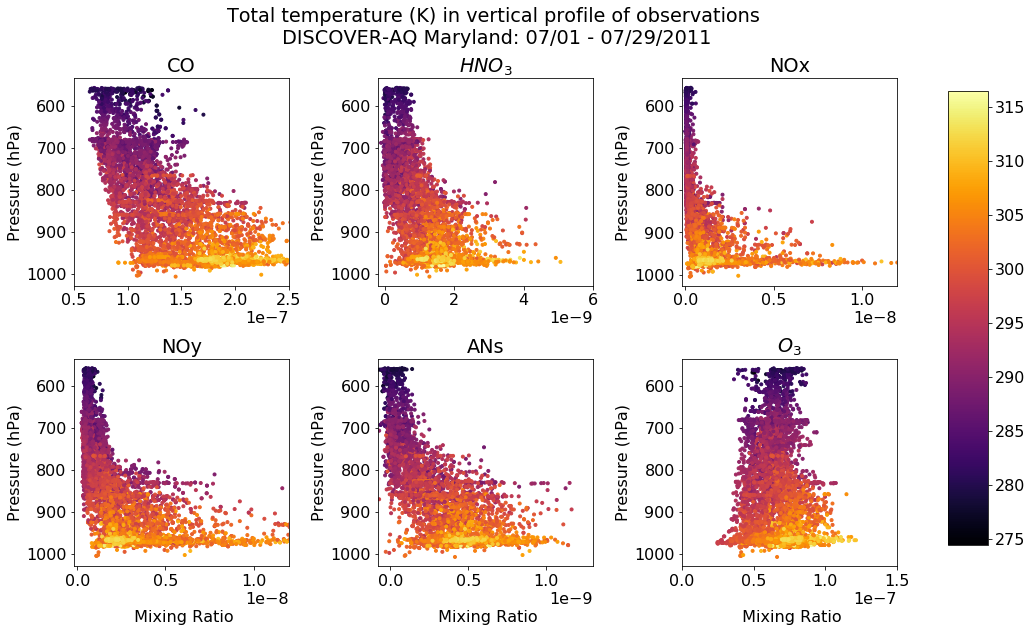

In [38]:
tt = metsub(dsc_obm, 'A_TotalTemp', 'inferno', 'Total temperature (K) in vertical profile of observations')
plt.savefig('disco/disco_tt.jpg')

##### Dew Point

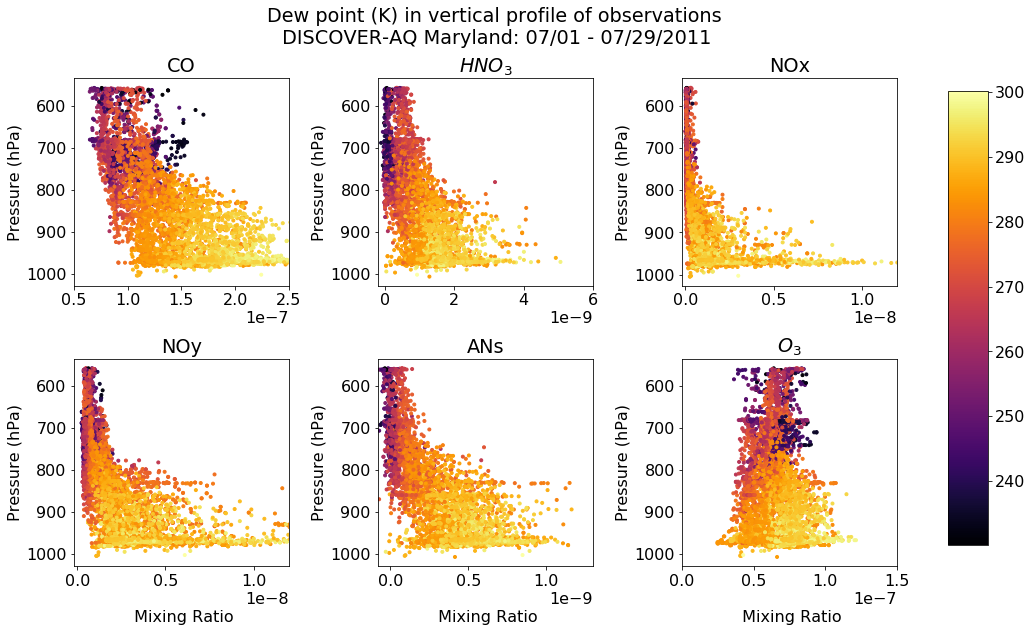

In [39]:
dp = metsub(dsc_obm, 'A_DewPoint', 'inferno', 'Dew point (K) in vertical profile of observations')
plt.savefig('disco/disco_dp.jpg')

### Moisture indicators

##### Relative Humidity

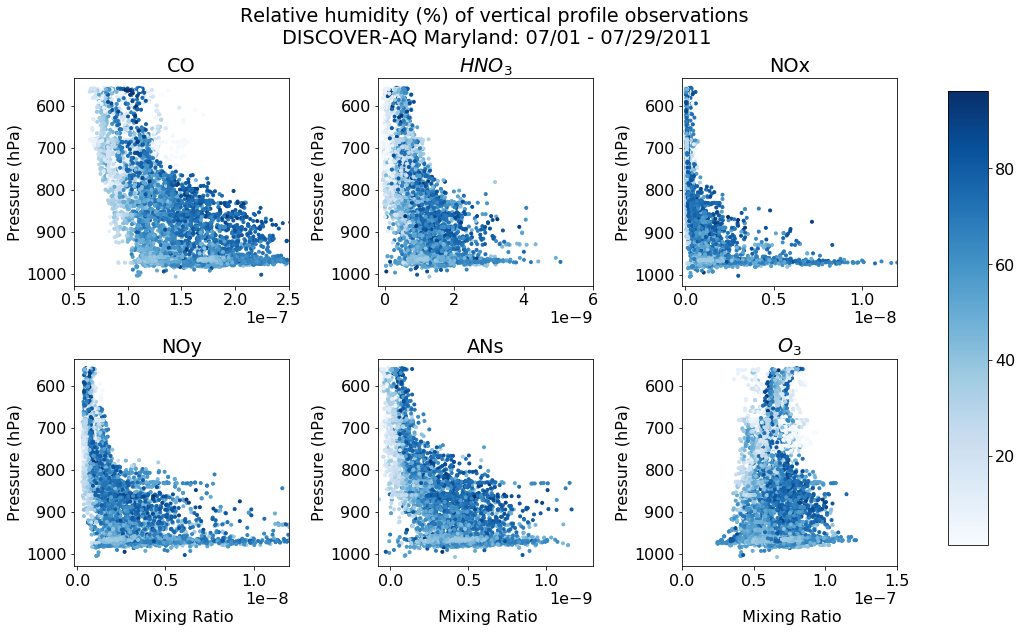

In [40]:
rh = metsub(dsc_obm, 'C_RelHumidity', 'Blues', 'Relative humidity (%) of vertical profile observations')
plt.savefig('disco/disco_rh.jpg')

##### $H_2O$ Mixing Ratio

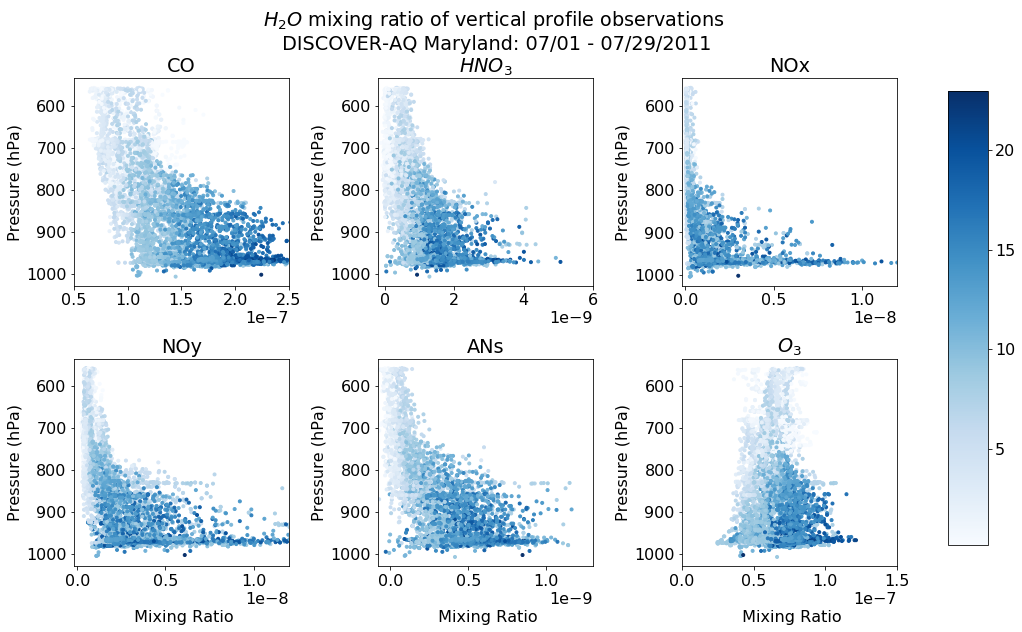

In [41]:
mr = metsub(dsc_obm, 'C_MixingRatio', 'Blues', r'$H_2O$' + ' mixing ratio of vertical profile observations')
plt.savefig('disco/disco_mr.jpg')

##### Vapor Pressure Deficit

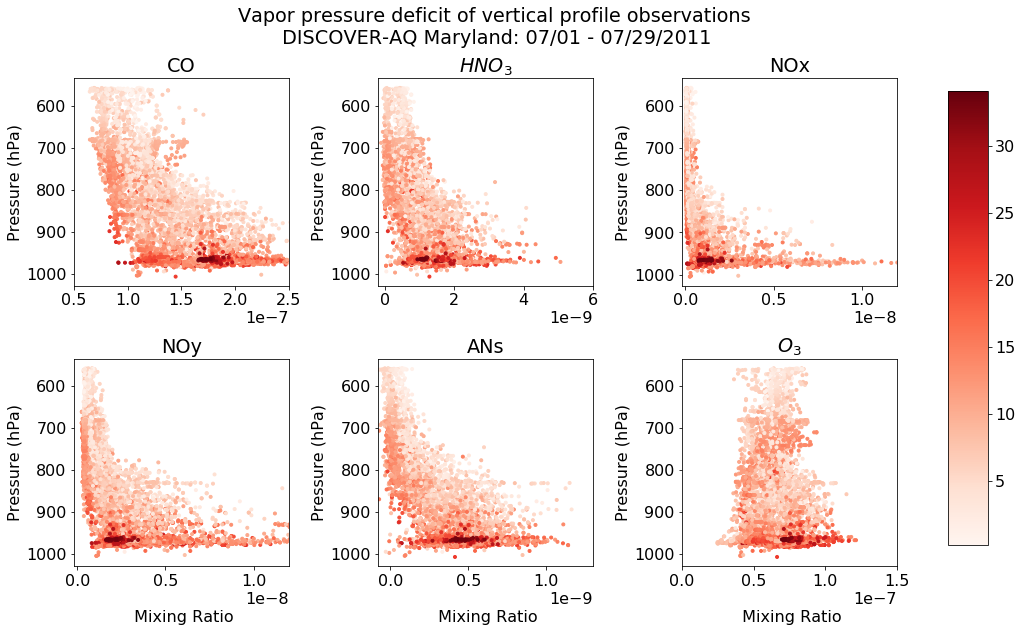

In [42]:
vp = metsub(dsc_obm, 'VPD', 'Reds', 'Vapor pressure deficit of vertical profile observations')
plt.savefig('disco/disco_vpd.jpg')

Note that DISCOVER-AQ MD did not measure radiation variables.